# $Universidade$ $Federal$ $de$ $Viçosa$ $(UFV)$ - Campus Viçosa

### Trabalho Final

**Alunos:** Erick Lima Figueiredo, Guilherme Oliveira Fonseca e Renan Lopes |
**MA:** 98898, 98889 e 97370

**Professor:** Lucas Nascimento Ferreira

**Disciplina:** Aprendizado em Redes Neurais Profundas (INF 721)


## Dataset: A neural network for classifying image data of natural scenes from around the world

**Source Dataset:** https://www.kaggle.com/datasets/puneet6060/intel-image-classification/data, https://www.kaggle.com/datasets/mahmoudreda55/satellite-image-classification/data

**Dataset Google Drive** https://drive.google.com/drive/folders/1hm0LIi2OD2-CirIbJa3E_4Rg9zyPuJoL?usp=sharing

**Code Repo:** https://github.com/renaops/IntelImageClassificationNN

**Google Colab:** https://colab.research.google.com/drive/1OSpWIk_VxjrZIXt47-DgpX5XCvpKjVMk


### 1. Importing Libraries

In [37]:
import os
import time
import math
import pandas as pd
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2 as transforms_v2

import seaborn as sns
import matplotlib.pyplot as plt

drive = None
try:
    from google.colab import drive
except Exception as e:
    print('Você está fora do google colab!')

%matplotlib inline


Você está fora do google colab!


In [2]:
USING_CUDA = torch.cuda.is_available()

f'Pytorch {"" if USING_CUDA else "não "}está usando o CUDA!'

'Pytorch está usando o CUDA!'

In [3]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


### 2. Dataset Loading

In [4]:
def get_content_from_partition(partition, data_path):
  partition_data = []
  for clazz in os.listdir(os.path.join(data_path, partition)):
    for img in os.listdir(os.path.join(data_path, partition, clazz)):
      if img.endswith('.jpg') or img.endswith('.png'):
        partition_data.append({'class': clazz, 'img': os.path.join(data_path, partition, clazz, img)})

  return partition_data

In [5]:
if drive:
    drive.mount('/content/drive', force_remount=True)
    data_path = '/content/drive/Shareddrives/Deep Learning'
else:
    data_path = './'

data_path += 'data'
print(f'Available partitions: {", ".join(os.listdir(data_path))}.')

Available partitions: test, train, validation.


In [6]:
train_df = pd.DataFrame(get_content_from_partition('train', data_path))
val_df = pd.DataFrame(get_content_from_partition('validation', data_path))
test_df = pd.DataFrame(get_content_from_partition('test', data_path))

In [7]:
train_df[train_df['img'].str.contains('.jpg')]

,class,img
0,cloudy,./data/train/cloudy/train_17406.jpg
1,cloudy,./data/train/cloudy/train_17504.jpg
2,cloudy,./data/train/cloudy/train_17505.jpg
3,cloudy,./data/train/cloudy/train_17513.jpg
4,cloudy,./data/train/cloudy/train_17549.jpg
...,...,...
3195,water,./data/train/water/SeaLake_2989.jpg
3196,water,./data/train/water/SeaLake_2990.jpg
3197,water,./data/train/water/SeaLake_2995.jpg
3198,water,./data/train/water/SeaLake_2999.jpg


In [8]:
print(f'> Train size: {len(train_df)}\n\n> Val size: {len(val_df)}\n\n> Test size: {len(test_df)}')

> Train size: 3200

> Val size: 1000

> Test size: 1431


[Text(0.5, 1.0, 'Train Class Distribution')]

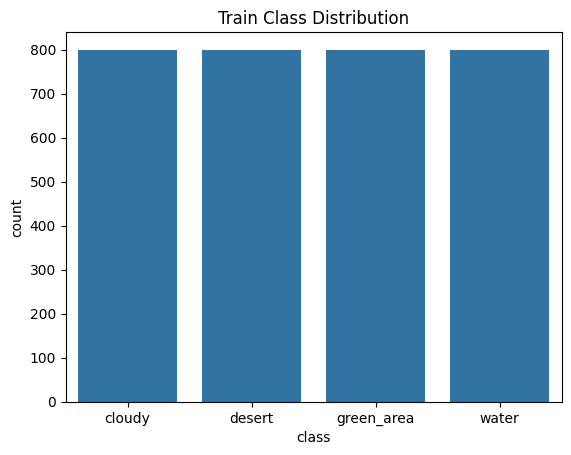

In [9]:
sns.countplot(x='class', data=train_df, order=sorted(train_df['class'].unique())).set(title='Train Class Distribution')

[Text(0.5, 1.0, 'Validation Class Distribution')]

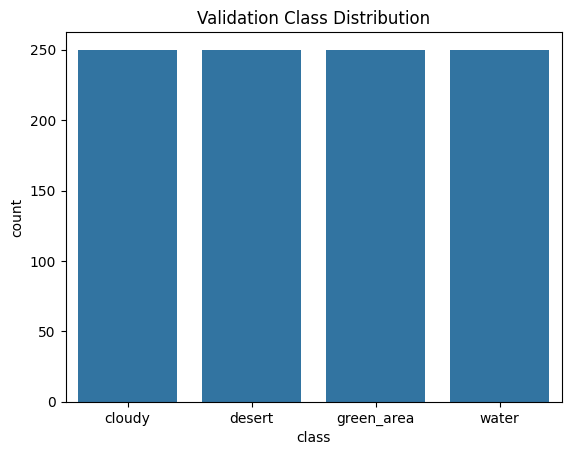

In [10]:
sns.countplot(x='class', data=val_df, order=sorted(val_df['class'].unique())).set(title='Validation Class Distribution')

[Text(0.5, 1.0, 'Test Class Distribution')]

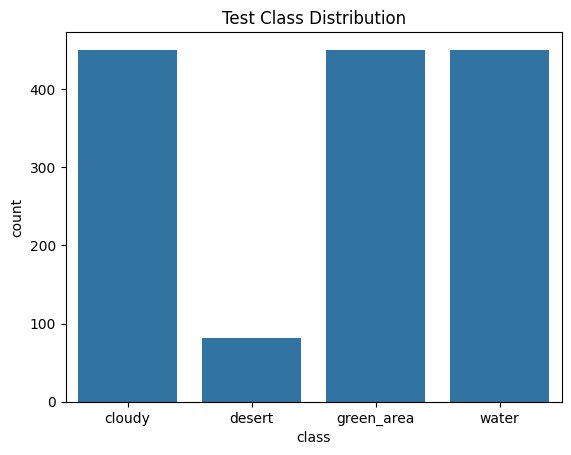

In [11]:
sns.countplot(x='class', data=test_df, order=sorted(test_df['class'].unique())).set(title='Test Class Distribution')

### 3. Preprocessing and Augmentation

In [12]:
class EnvironmentsDataset(Dataset):
  def __init__(self, df, transform=None, target_name='class', shuffle=True):
    self._data = self._shuffle(df) if shuffle else df
    self._transform = transform
    self._class_names = list(self.data[target_name].unique())

  @property
  def class_names(self):
    return self._class_names

  @property
  def data(self):
    return self._data

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    img = read_image(self._data.loc[idx, 'img'])[:3, :, :]
    
    label = self._class_names.index(self._data.loc[idx, 'class'])

    if self._transform:
      img = self._transform(img)

    return img, label

  def _shuffle(self, df):
    return df.sample(frac=1).reset_index(drop=True)

In [13]:
transfs = transforms_v2.Compose([
    transforms_v2.ToDtype(torch.float32, scale=True),
    transforms.Resize(size=(224, 224), antialias=True),
    transforms_v2.RandomRotation(degrees=(-45, 45)),
    transforms_v2.RandomHorizontalFlip(p=0.5),
])


In [14]:
train_dataset = EnvironmentsDataset(train_df, transform=transfs)
val_dataset = EnvironmentsDataset(val_df, transform=transfs)
test_dataset = EnvironmentsDataset(test_df, transform=transfs)

This is a water



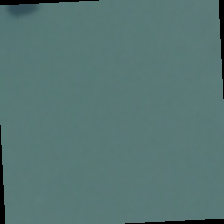

In [15]:
# Para visualizar a imagem normal, comente a ultima linha do Transformer Compose
print('This is a ' + train_dataset.class_names[train_dataset[0][1]], end='\n\n')
transforms.ToPILImage()(train_dataset[0][0])

# 4. Model Architecture and Training

In [39]:
BATCH_SIZE = 32
NUM_EPOCHS = 50
NUM_CLASSES = len(train_dataset.class_names)
MODEL_SAVE_PATH = './models'
MODEL_NAME = 'satellite_vision'

In [38]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [18]:
class EnvClassificationNet(nn.Module):
    def __init__(self, num_classes):
      super(EnvClassificationNet, self).__init__()

      self.pool = nn.MaxPool2d((2, 2))

      self.conv1 = nn.Conv2d(3, 32, 3)
      self.batch1 = nn.BatchNorm2d(32)
      self.conv2 = nn.Conv2d(32, 32, 3)
      self.batch2 = nn.BatchNorm2d(32)
      self.dropout1 = nn.Dropout(.3)

      self.conv3 = nn.Conv2d(32, 64, 3)
      self.batch3 = nn.BatchNorm2d(64)
      self.conv4 = nn.Conv2d(64, 64, 3)
      self.batch4 = nn.BatchNorm2d(64)
      self.dropout2 = nn.Dropout(.5)

      self.conv5 = nn.Conv2d(64, 128, 3)
      self.batch5 = nn.BatchNorm2d(128)
      self.conv6 = nn.Conv2d(128, 128, 3)
      self.batch6 = nn.BatchNorm2d(128)
      self.dropout3 = nn.Dropout(.5)

      self.fc1 = nn.Linear(128 * 24 * 24, 128)
      self.batch7 = nn.BatchNorm1d(128)
      self.dropout4 = nn.Dropout(.5)
      self.out = nn.Linear(128, num_classes)

    def forward(self, x):
      x = F.relu(self.conv1(x))
      x = self.batch1(x)
      x = F.relu(self.conv2(x))
      x = self.batch2(x)
      x = self.pool(x)
      x = self.dropout1(x)

      x = F.relu(self.conv3(x))
      x = self.batch3(x)
      x = F.relu(self.conv4(x))
      x = self.batch4(x)
      x = self.pool(x)
      x = self.dropout2(x)

      x = F.relu(self.conv5(x))
      x = self.batch5(x)
      x = F.relu(self.conv6(x))
      x = self.batch6(x)
      x = self.pool(x)
      x = self.dropout3(x)

      x = x.view(-1, 128 * 24 * 24)

      x = F.relu(self.fc1(x))
      x = self.batch7(x)
      x = self.dropout4(x)
      x = self.out(x)

      return x


In [19]:
def calc_val_loss(model, dataloader, loss_function):
  with torch.no_grad():
    total = .0
    for batch in dataloader:
      imgs, labels = batch

      if USING_CUDA:  
          imgs = imgs.to('cuda')
          labels = labels.to('cuda')

      total += loss_function(model(imgs), labels).item()

    return total / len(dataloader)

In [20]:
def format_time(seconds):
    if seconds < 60:
        return f'{seconds:.2f}s'
    else:
        m, s = divmod(seconds, 60)
        h, m = divmod(m, 60)
        
        return f'{int(m)}m{s:.2f}s' if h <= 0 else f'{h}h{int(m)}m{s:.2f}s'


In [27]:
def plot_learning_curve(train_losses, val_losses, num_epochs, size=(8, 5)):
    plt.figure(figsize=size)
    plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linestyle='-', color='#ff5a7d')
    plt.plot(range(1, num_epochs + 1), val_losses, marker='x', linestyle='-', color='#ff9e00')

    plt.title('Learning Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Average Loss')
    plt.show()

In [21]:
model = EnvClassificationNet(NUM_CLASSES)

if USING_CUDA:
    model.cuda()

In [22]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [23]:
def optimize(model, train_loader, val_loader, loss_func, optimizer, num_epochs, output_path):
  train_losses = []
  val_losses = []

  for epoch in range(1, num_epochs + 1):
    start_time = time.time()
    total_time = 0
    total_loss = .0

    print(f'Epoch: {epoch}/{num_epochs}')
    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()
        imgs, labels = batch

        if USING_CUDA:  
          imgs = imgs.to('cuda')
          labels = labels.to('cuda')

        loss = loss_func(model(imgs), labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        iteration_time = time.time() - start_time
        total_time += iteration_time

        avg_iteration_time = total_time / (i + 1)
        remaining_iterations = len(train_loader) - (i + 1)
        remaining_time = remaining_iterations * avg_iteration_time

        completion_percentage = (i + 1) / len(train_loader) * 100
        formatted_completion_percentage = math.floor(completion_percentage / 3.333)

        print(f'\r{i+1}/{len(train_loader)} [{"="*(formatted_completion_percentage)}{"."*(30 - formatted_completion_percentage)}] - {format_time(iteration_time)}/step - Loss: {loss:.6f} - {"Total Time" if i+1 == len(train_loader) else "ETA"}: {format_time(total_time) if i+1 == len(train_loader) else format_time(remaining_time)}', end='', flush=True)

    train_losses.append(total_loss / len(train_loader))
    val_losses.append(calc_val_loss(model, val_loader, loss_func))
    print(f" || Train Loss:{train_losses[-1]:.6f} - Val Loss:{val_losses[-1]:.6f}")

  print('\nComplete! =)')
  torch.save(model.state_dict(), output_path)

  return train_losses, val_losses

In [24]:
train_losses, val_losses = optimize(model, train_loader, val_loader, loss_func, optimizer, NUM_EPOCHS, os.path.join(MODEL_SAVE_PATH, MODEL_NAME + '.pth'))

Epoch: 1/50
100/100 [==============================] - 11.39s/step - Loss: 0.574007 - Total Time: 9m59.03s || Train Loss:0.434421 - Val Loss:5.598494
Epoch: 2/50
100/100 [==============================] - 11.03s/step - Loss: 0.192472 - Total Time: 9m34.14s || Train Loss:0.351961 - Val Loss:6.041498
Epoch: 3/50
100/100 [==============================] - 11.07s/step - Loss: 0.256732 - Total Time: 9m31.24s || Train Loss:0.347413 - Val Loss:6.331857
Epoch: 4/50
100/100 [==============================] - 10.99s/step - Loss: 0.161752 - Total Time: 9m26.99s || Train Loss:0.288813 - Val Loss:6.764087
Epoch: 5/50
100/100 [==============================] - 11.06s/step - Loss: 0.119959 - Total Time: 9m33.69s || Train Loss:0.294848 - Val Loss:6.570478
Epoch: 6/50
100/100 [==============================] - 11.29s/step - Loss: 0.237367 - Total Time: 9m47.75s || Train Loss:0.303377 - Val Loss:6.568179
Epoch: 7/50
100/100 [==============================] - 11.15s/step - Loss: 0.082453 - Total Time: 9m

### 5. Model Evaluation

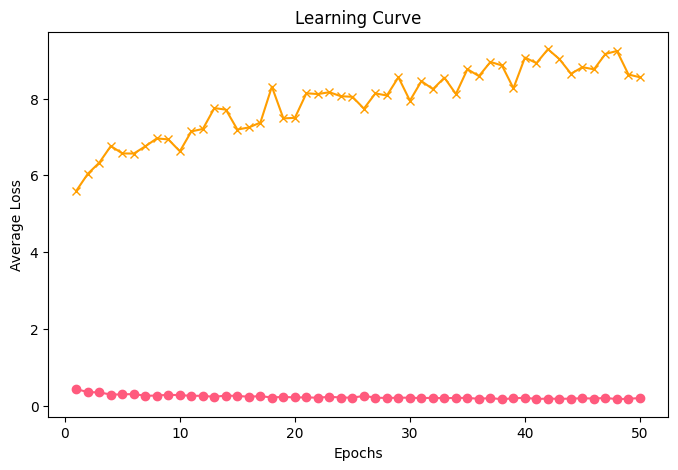

In [28]:
plot_learning_curve(train_losses, val_losses, NUM_EPOCHS)

In [36]:
def evaluate_model_accuracy(model, dataloader, num_classes):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for imgs, labels in dataloader:
            if USING_CUDA:  
                imgs = imgs.to('cuda')
                labels = labels.to('cuda')

            preds = torch.argmax(model(imgs).data, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = (sum([1 for i, j in zip(all_preds, all_labels) if i == j]) / len(all_labels))
    confusion_mat = confusion_matrix(all_labels, all_preds, labels=range(num_classes))

    return accuracy, confusion_mat
  

In [34]:
# Adicionar aqui a opção de carregar o modelo para a memória

model.eval()

train_accuracy, conf_mtrx_train = evaluate_model_accuracy(model, train_loader, NUM_CLASSES)
test_accuracy, conf_mtrx_test = evaluate_model_accuracy(model, test_loader, NUM_CLASSES)

print("Train accuracy:", train_accuracy)
print("Test accuracy:", test_accuracy)

Train accuracy: 0.945
Test accuracy: 0.050314465408805034
